# 1. Preparation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import OrderedDict
import torch
from torchvision.models import detection
import matplotlib.pyplot as plt
from myutils.pytorch import module_util
from models.org import rcnn

# 2. Complexity analysis

In [3]:
def get_hierarchized_dict(component_names):
    children_dict = OrderedDict()
    for component_name in component_names:
        elements = component_name.split('.')
        if elements[0] not in children_dict and len(elements) == 1:
            children_dict[elements[0]] = component_name
            continue
        elif elements[0] not in children_dict:
            children_dict[elements[0]] = list()
        children_dict[elements[0]].append('.'.join(elements[1:]))
        
    for key in children_dict.keys():
        value = children_dict[key]
        if isinstance(value, list) and len(value) > 1:
            children_dict[key] = get_hierarchized_dict(value)
    return children_dict


def decompose(ordered_dict):
    component_list = list()
    for key, value in ordered_dict.items():
        if isinstance(value, OrderedDict):
            component_list.append((key, decompose(value)))
        elif isinstance(value, list):
            component_list.append((key, value))
        else:
            component_list.append(key)
    return component_list

def get_components(component_names):
    ordered_dict = get_hierarchized_dict(component_names)
    return decompose(ordered_dict)

In [4]:
def count_model_params(module, components, count_list):
    count = 0
    for component in components:
        child_components = None
        sub_count_list = list()
        if isinstance(component, tuple):
            component_name, child_components = component
        else:
            component_name = component

        assert hasattr(module, component_name)
        sub_module = getattr(module, component_name)
        sub_count = module_util.count_params(sub_module) if child_components is None else count_model_params(sub_module, child_components, sub_count_list)
        count_list.append(sub_count if child_components is None else sub_count_list)
        count += sub_count
    
    assert count == module_util.count_params(module)
    return count


def flatten(elements):
    sub_list = list()
    successful = True
    for element in elements:
        if isinstance(element, (list, tuple)):
            sub_list.extend(element)
            successful = False
        else:
            sub_list.append(element)
    
    return sub_list if successful else flatten(sub_list)


def get_flat_param_counts(model, components):
    param_count_list = list()
    num_params = count_model_params(model, components, param_count_list)
    flat_param_count_list = list()
    flat_component_list = list()
    for param_count in param_count_list:
        if isinstance(param_count, (list, tuple)):
            flat_param_count_list.extend(flatten(param_count))
        else:
            flat_param_count_list.append(param_count)
    return flat_param_count_list


def analyze_models(models, component_names, model_names):
    components = get_components(component_names)
    xs = list(range(len(component_names)))
    for model, model_name in zip(models, model_names):
        flat_param_counts = get_flat_param_counts(model, components)
        accum_param_counts = [sum(flat_param_counts[:i+1]) for i in xs]
        plt.plot(xs, accum_param_counts, label=model_name)
    
    plt.xticks(xs, component_names, rotation='vertical')
    plt.xlabel('Main layers')
    plt.ylabel('Accumulated number of parameters')
    plt.legend()
    plt.show()

In [5]:
rcnn_component_names = [
    'backbone.body.conv1',
    'backbone.body.bn1',
    'backbone.body.relu',
    'backbone.body.maxpool',
    'backbone.body.layer1',
    'backbone.body.layer2',
    'backbone.body.layer3',
    'backbone.body.layer4',
    'backbone.fpn',
    'rpn',
    'roi_heads'
]

## 2.1 Faster R-CNN

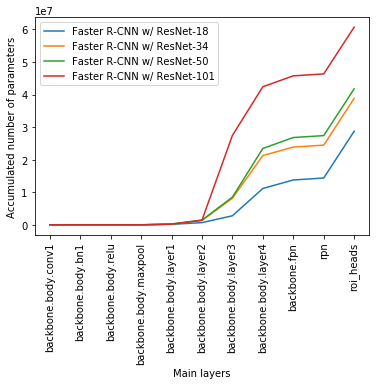

In [6]:
faster_rcnn_backbone_resnet18 = rcnn.get_model('faster_rcnn', False, 'resnet18', False)
faster_rcnn_backbone_resnet34 = rcnn.get_model('faster_rcnn', False, 'resnet34', False)
faster_rcnn_backbone_resnet50 = rcnn.get_model('faster_rcnn', False, 'resnet50', False)
faster_rcnn_backbone_resnet101 = rcnn.get_model('faster_rcnn', False, 'resnet101', False)
faster_rcnns = [faster_rcnn_backbone_resnet18, faster_rcnn_backbone_resnet34, faster_rcnn_backbone_resnet50, faster_rcnn_backbone_resnet101]
analyze_models(faster_rcnns, rcnn_component_names, ['Faster R-CNN w/ ResNet-18', 'Faster R-CNN w/ ResNet-34', 'Faster R-CNN w/ ResNet-50', 'Faster R-CNN w/ ResNet-101'])

## 2.2 Mask R-CNN

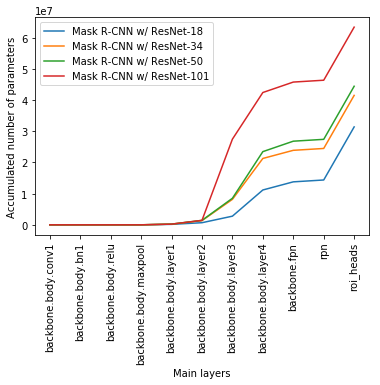

In [7]:
mask_rcnn_backbone_resnet18 = rcnn.get_model('mask_rcnn', False, 'resnet18', False)
mask_rcnn_backbone_resnet34 = rcnn.get_model('mask_rcnn', False, 'resnet34', False)
mask_rcnn_backbone_resnet50 = rcnn.get_model('mask_rcnn', False, 'resnet50', False)
mask_rcnn_backbone_resnet101 = rcnn.get_model('mask_rcnn', False, 'resnet101', False)
mask_rcnns = [mask_rcnn_backbone_resnet18, mask_rcnn_backbone_resnet34, mask_rcnn_backbone_resnet50, mask_rcnn_backbone_resnet101]
analyze_models(mask_rcnns, rcnn_component_names, ['Mask R-CNN w/ ResNet-18', 'Mask R-CNN w/ ResNet-34', 'Mask R-CNN w/ ResNet-50', 'Mask R-CNN w/ ResNet-101'])

## 2.3 Keypoint R-CNN

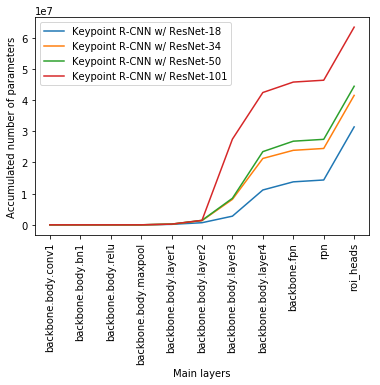

In [8]:
keypoint_rcnn_backbone_resnet18 = rcnn.get_model('keypoint_rcnn', False, 'resnet18', False, num_classes=2)
keypoint_rcnn_backbone_resnet34 = rcnn.get_model('keypoint_rcnn', False, 'resnet34', False, num_classes=2)
keypoint_rcnn_backbone_resnet50 = rcnn.get_model('keypoint_rcnn', False, 'resnet50', False, num_classes=2)
keypoint_rcnn_backbone_resnet101 = rcnn.get_model('keypoint_rcnn', False, 'resnet101', False, num_classes=2)
keypoint_rcnns = [keypoint_rcnn_backbone_resnet18, keypoint_rcnn_backbone_resnet34, keypoint_rcnn_backbone_resnet50, keypoint_rcnn_backbone_resnet101]
analyze_models(mask_rcnns, rcnn_component_names, ['Keypoint R-CNN w/ ResNet-18', 'Keypoint R-CNN w/ ResNet-34', 'Keypoint R-CNN w/ ResNet-50', 'Keypoint R-CNN w/ ResNet-101'])